<a href="https://colab.research.google.com/github/Gerundio98/Cedula.Desarrollo-de-Software-II/blob/main/M22_CNN_RodolfoPena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import numpy as np
import cv2



# 1. Carga del modelo CNN preentrenado y el conjunto de datos MNIST

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)
model.evaluate(X_test, y_test)



11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/5
1500/1500 [==============================] - 56s 35ms/step - loss: 0.1467 - accuracy: 0.9552 - val_loss: 0.0577 - val_accuracy: 0.9832
Epoch 2/5
1500/1500 [==============================] - 46s 31ms/step - loss: 0.0487 - accuracy: 0.9843 - val_loss: 0.0500 - val_accuracy: 0.9840
Epoch 3/5
1500/1500 [==============================] - 46s 31ms/step - loss: 0.0318 - accuracy: 0.9896 - val_loss: 0.0351 - val_accuracy: 0.9903
Epoch 4/5
1500/1500 [==============================] - 43s 29ms/step - loss: 0.0223 - accuracy: 0.9927 - val_loss: 0.0446 - val_accuracy: 0.9870
Epoch 5/5
313/313 [==============================] - 3s 10ms/step - loss: 0.0310 - accuracy: 0.9902


[0.031034020707011223, 0.9901999831199646]

# 2. Selección de una imagen de prueba

In [3]:

test_image = X_test[0]
test_label = y_test[0]



# 3. Clasificación de la imagen

In [4]:

prediction = np.argmax(model.predict(np.expand_dims(test_image, axis=0)), axis=-1)
print(f'Predicted class: {prediction}, True class: {test_label}')



1/1 [==============================] - 0s 197ms/step
Predicted class: [7], True class: 7


# 4. Visualización de activaciones


1/1 [==============================] - 0s 64ms/step


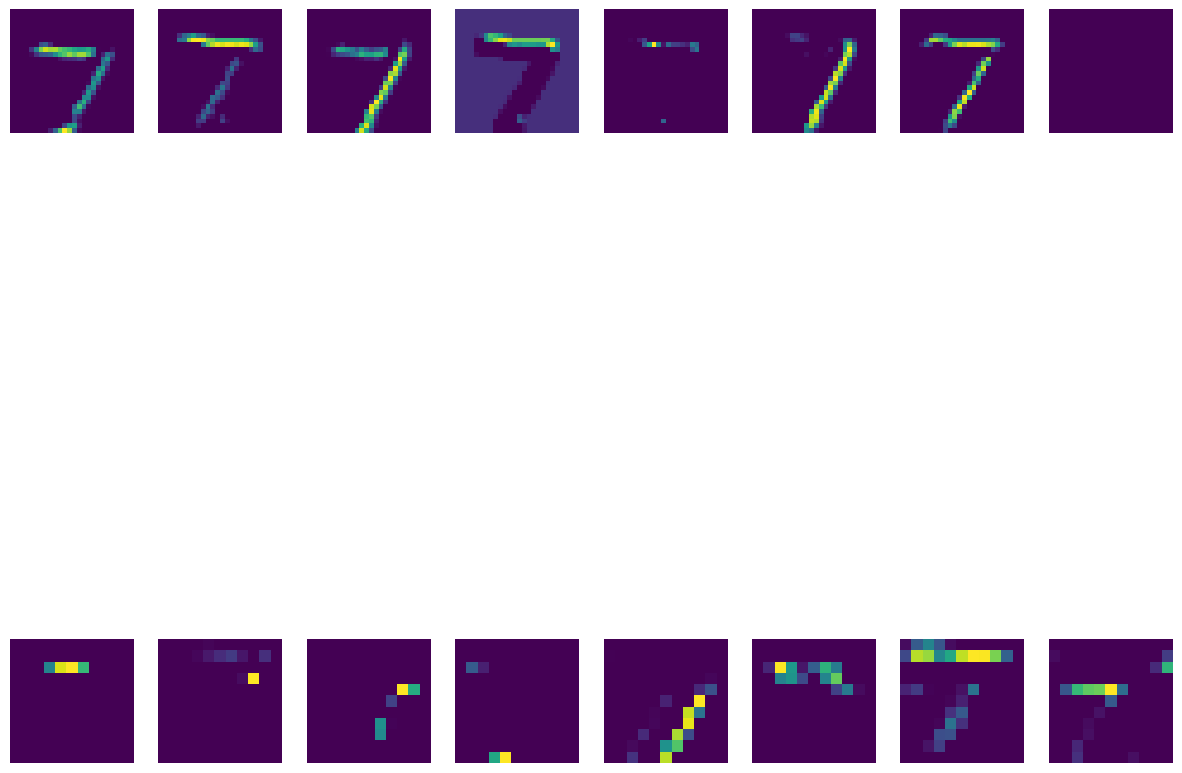

In [10]:
# Ejecutar el modelo al menos una vez para que tenga definidos sus inputs
model.predict(np.expand_dims(test_image, axis=0))

layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(np.expand_dims(test_image, axis=0))

# Plotting the activations
fig, axes = plt.subplots(len(activations), 8, figsize=(15, 15))
for i, activation in enumerate(activations):
    for j in range(min(8, activation.shape[-1])):  # ensure we don't go out of bounds
        axes[i, j].imshow(activation[0, :, :, j], cmap='viridis')
        axes[i, j].axis('off')
plt.show()

# 5. Creación de mapas de calor con Grad-CAM

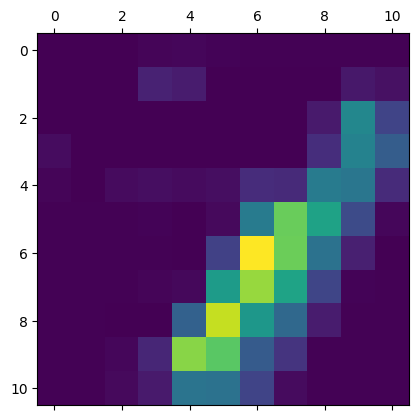

In [9]:

def get_gradcam_heatmap(model, img, class_index, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img, axis=0))
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

heatmap = get_gradcam_heatmap(model, test_image, prediction[0], 'conv2d_1')

plt.matshow(heatmap)
plt.show()



# 6. Análisis e interpretación

In [11]:

print("""
Las imágenes de activaciones muestran cómo las primeras capas convolucionales capturan características simples del dígito "7".
Se observan contornos básicos y estructuras del número, como las líneas horizontales y diagonales que forman el "7".

Por su parte las activaciones de las capas intermedias y finales capturan características más complejas y combinaciones de las características simples detectadas en las primeras capas.
Esto ayuda al modelo a distinguir el dígito con mayor precisión a medida que las capas avanzan.

El mapa de calor generado con Grad-CAM muestra las áreas de la imagen del dígito "7" que más contribuyen a la clasificación del modelo.
Las áreas más calientes (amarillo y verde) indican que el modelo se enfoca en las líneas diagonales y horizontales, que son características definitorias del "7".
""")



Las imágenes de activaciones muestran cómo las primeras capas convolucionales capturan características simples del dígito "7".
Se observan contornos básicos y estructuras del número, como las líneas horizontales y diagonales que forman el "7".

Por su parte las activaciones de las capas intermedias y finales capturan características más complejas y combinaciones de las características simples detectadas en las primeras capas.
Esto ayuda al modelo a distinguir el dígito con mayor precisión a medida que las capas avanzan.

El mapa de calor generado con Grad-CAM muestra las áreas de la imagen del dígito "7" que más contribuyen a la clasificación del modelo.
Las áreas más calientes (amarillo y verde) indican que el modelo se enfoca en las líneas diagonales y horizontales, que son características definitorias del "7".



# 7. Conclusiones

In [12]:
print("""
- Las visualizaciones de activaciones muestran cómo el modelo CNN extrae características importantes de la imagen de un dígito a través de sus capas convolucionales.
- El mapa de calor de Grad-CAM resalta las regiones específicas de la imagen que son más influyentes para la decisión de clasificación del modelo.
- Estas técnicas de interpretabilidad proporcionan una comprensión profunda de cómo el modelo CNN procesa las imágenes y toman decisiones, lo cual es esencial para confiar en sus predicciones y mejorar su diseño.
""")


- Las visualizaciones de activaciones muestran cómo el modelo CNN extrae características importantes de la imagen de un dígito a través de sus capas convolucionales.
- El mapa de calor de Grad-CAM resalta las regiones específicas de la imagen que son más influyentes para la decisión de clasificación del modelo.
- Estas técnicas de interpretabilidad proporcionan una comprensión profunda de cómo el modelo CNN procesa las imágenes y toman decisiones, lo cual es esencial para confiar en sus predicciones y mejorar su diseño.

